In [1]:
import math
import sys

import IPython
import IPython.display as ipd
import matplotlib.pylab as plt
import numpy as np
import pandas as pd

%reload_ext autoreload
%autoreload 2

%matplotlib inline
#%matplotlib notebook

from matplotlib import rcParams
import matplotlib.font_manager
#print([k for k in rcParams.keys() if "figure" in k])
plt.rcParams.update({
    "figure.figsize": (10, 5),
    "figure.max_open_warning": False,
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

In [2]:
sys.path.append("../crazyflie-audio/python/")
from bin_selection import select_frequencies
from crazyflie_description_py.parameters import N_BUFFER, FS, FFTSIZE

DURATION_PER_FREQ = 0.5
DURATION_SEC = DURATION_PER_FREQ * FFTSIZE
print(DURATION_SEC)


def buzzer_signal(source):
    from signals import generate_signal

    kwargs = dict(duration_sec=DURATION_SEC, max_dB=-10, Fs=FS,)
    frequencies = np.fft.rfftfreq(N_BUFFER, 1 / FS)
    if source == "mono4125":
        return generate_signal(signal_type="mono", frequency_hz=4125, **kwargs)
    elif source == "random":
        return generate_signal(signal_type="random", **kwargs)
    elif source == "multi":
        phase = np.random.uniform(0, 2 * np.pi)
        signal = generate_signal(
            signal_type="mono",
            frequency_hz=frequencies[1],
            **kwargs,
            phase_offset=phase,
        )
        for f in frequencies[2:]:
            phase = np.random.uniform(0, 2 * np.pi)
            signal += generate_signal(
                signal_type="mono", frequency_hz=f, **kwargs, phase_offset=phase
            )
        return signal
    elif source == "sweep":
        # duration of each frequency bin
        min_freq = 100
        max_freq = 4400

        bins = select_frequencies(
            n_buffer=N_BUFFER, fs=FS, min_freq=min_freq, max_freq=max_freq
        )

        duration_all = len(bins) * duration_per_freq
        signal = np.zeros(int(FS * duration_all))
        idx = 0
        for f in frequencies[bins]:

            kwargs["duration_sec"] = duration_per_freq
            mono = generate_signal(signal_type="mono", frequency_hz=f, **kwargs)
            signal[idx : idx + len(mono)] = mono
            idx += len(mono)
        return signal
    else:
        raise ValueError(source)


signals = {}
for key in ["mono4125", "random", "multi", "sweep"]:
    try:
        signal = pd.read_pickle(f"results/{key}.pk")
        print(f"read {key}")
    except:
        signal = buzzer_signal(key)
        pd.to_pickle(signal, f"results/{key}.pk")
        print(f"saved {key}")
    signals[key] = signal

16.0
read mono4125
read random
read multi
read sweep


In [3]:
def matrix_slices(
    df_matrix,
    frequencies,
    distances,
    saveas="",
    ymin=None,
    ymax=None,
    start_freq=1000,
    start_dist=30,
):
    from ipywidgets import (
        interact,
        interactive,
        fixed,
        interact_manual,
        FloatSlider,
        IntSlider,
    )
    import ipywidgets as widgets
    from plotting_tools import save_fig

    def update_figure(slice_f, slice_d):
        fig, axs = plt.subplots(1, 2)
        fig.set_size_inches(10, 5)
        # axs[0].semilogy(distances, df_matrix[slice_f, :])
        axs[0].plot(distances, df_matrix[slice_f, :])
        axs[0].set_title(f"frequency = {frequencies[slice_f]:.0f} Hz")
        axs[0].set_xlabel("distance [cm]")
        axs[0].set_ylabel("amplitude [-]")
        axs[0].set_ylim(ymin, ymax)

        # axs[1].semilogy(frequencies, df_matrix[:, slice_d])
        axs[1].plot(frequencies, df_matrix[:, slice_d])
        axs[1].set_title(f"distance = {distances[slice_d]:.0f} cm")
        axs[1].set_xlabel("frequency [Hz]")
        axs[1].set_ylabel("amplitude [-]")
        axs[1].set_ylim(ymin, ymax)
        if saveas != "":
            save_fig(fig, saveas)
        plt.show()

    start_freq_index = np.argmin(np.abs(start_freq - frequencies))
    start_dist_index = np.argmin(np.abs(start_dist - distances))
    interactive_plot = interact(
        update_figure,
        slice_f=IntSlider(
            start_freq_index, min=0, max=len(frequencies) - 1, continuous_update=False
        ),
        slice_d=IntSlider(
            start_dist_index, min=0, max=len(distances) - 1, continuous_update=False
        ),
    )

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


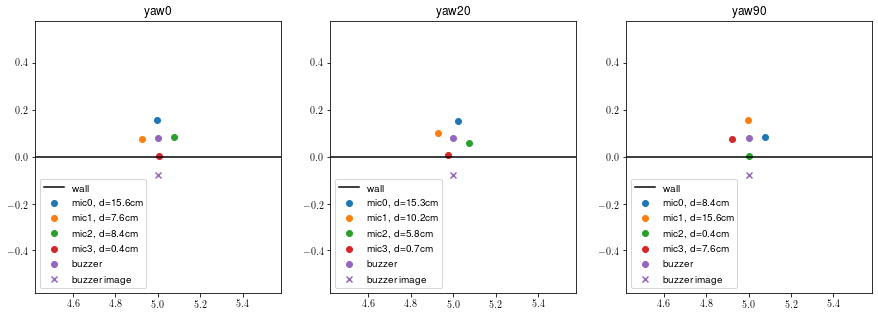

In [4]:
from simulation import generate_room
angles = [0, 20, 90]
fig, axs = plt.subplots(1, len(angles), squeeze=False)
fig.set_size_inches(5*len(angles), 5)
for ax, angle in zip(axs.flatten(), angles):
    room = generate_room(distance_cm=0, yaw_deg=angle, ax=ax)
    ax.set_title(f'yaw{angle}')
    ax.legend(loc="lower left")

(-8.168216612506114, 10.865153172024103, -8.033369784530215, 8.033369784530215)

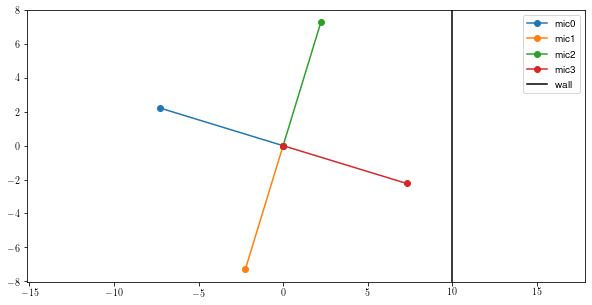

In [5]:
from simulation import get_df_theory_simple, get_deltas_from_global
fig, ax = plt.subplots()
for i in range(4):
    deltas = get_deltas_from_global(20, 0, i, ax)
ax.axvline(10, color='black', label='wall')
ax.legend()
ax.axis('equal')

# Distance-frequency matrix

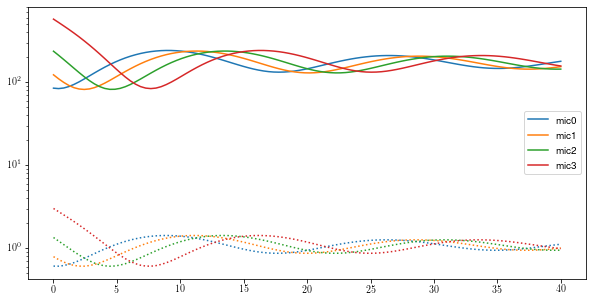

In [6]:
from simulation import get_dist_slice_pyroom, get_dist_slice_theory

yaw_deg = 20
distances_cm = np.linspace(0, 40, 100)
frequency = 1000

Hs = get_dist_slice_pyroom(frequency, distances_cm=distances_cm, yaw_deg=yaw_deg)
Hs_theo = get_dist_slice_theory(frequency, distances_cm=distances_cm, yaw_deg=yaw_deg)
fig, ax = plt.subplots()
for i in range(Hs.shape[1]):
    ax.plot(distances_cm, Hs[:, i], label=f"mic{i}", ls="-", color=f"C{i}")
    ax.plot(distances_cm, Hs_theo[:, i], ls=":", color=f"C{i}")
ax.set_yscale('log')
ax.legend()

[0.2, 12.72222779205292, -0.2518620780029936]
[0.2, 12.804820495885053, -0.37152794306311127]


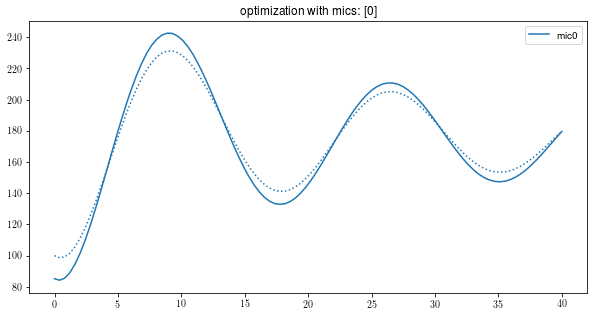

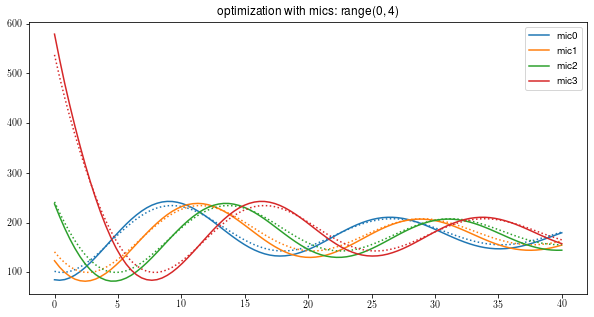

In [7]:
from calibration import fit_distance_slice
for chosen_mics in [[0], range(4)]:
    coeffs, d_slice, cost = fit_distance_slice(Hs, distances_cm, yaw_deg, frequency, chosen_mics)
    print(coeffs)
    fig, ax = plt.subplots()
    for i, mic in enumerate(chosen_mics):
        ax.plot(distances_cm, Hs[:, i], label=f"mic{mic}", ls="-", color=f"C{mic}")
        ax.plot(distances_cm, d_slice[:, i], ls=":", color=f"C{mic}")
    ax.legend()
    ax.set_title(f'optimization with mics: {chosen_mics}')

In [8]:
from simulation import get_freq_slice_pyroom
import progressbar

mic_idx = 1
distances = np.linspace(0, 60, 100)
frequencies = np.fft.rfftfreq(N_BUFFER, 1 / FS)

fname = "results/df_matrix_pyroom.pkl"
try:
    series_all = pd.read_pickle(fname)
    print("read", fname)
    np.testing.assert_allclose(series_all.distances, distances)
    np.testing.assert_allclose(series_all.frequencies, frequencies)
    df_matrix = series_all.df_matrix
except Exception as e:
    print(e)
    df_matrix = np.zeros((len(frequencies), len(distances)))

    signal = signals["multi"]
    with progressbar.ProgressBar(max_value=len(distances) - 1) as bar:
        for j, distance_cm in enumerate(distances):
            slice_mics = get_freq_slice_pyroom(frequencies, distance_cm, signal=signal)
            df_matrix[:, j] = slice_mics[mic_idx]
            bar.update(j)
    series = pd.Series(
        {"df_matrix": df_matrix, "distances": distances, "frequencies": frequencies}
    )
    pd.to_pickle(series, fname)
    print("saved as", fname)

read results/df_matrix_pyroom.pkl


In [9]:
min_freq = 100
max_freq = 5000
min_dist = 1
max_dist = 50
freq_start = int(min_freq / max(frequencies) * len(frequencies))
freq_end = int(max_freq / max(frequencies) * len(frequencies))
dist_start = int(min_dist / max(distances) * len(distances))
dist_end = int(max_dist / max(distances) * len(distances))

dist = distances[dist_start:dist_end]
freq = frequencies[freq_start:freq_end]

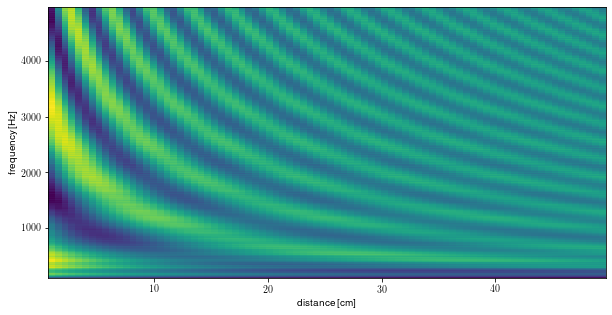

interactive(children=(IntSlider(value=58, continuous_update=False, description='slice_f', max=313), IntSlider(…

In [10]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 5)
ax.pcolorfast(dist, freq, df_matrix[freq_start:freq_end, dist_start:dist_end])
plt.xlabel("distance [cm]")
plt.ylabel("frequency [Hz]")
matrix_slices(
    df_matrix[freq_start:freq_end, dist_start:dist_end],
    freq,
    dist,
    ymin=8,
    ymax=20,
)

In [11]:
from simulation import get_freq_slice_theory
df_matrix_theo = np.empty((len(frequencies), len(distances)))
for j, distance_cm in enumerate(distances):
    slice_mics = get_freq_slice_theory(frequencies, distance_cm)
    df_matrix_theo[:, j] = slice_mics[:, mic_idx]

saved as plots/distance-frequency-matrix.pdf


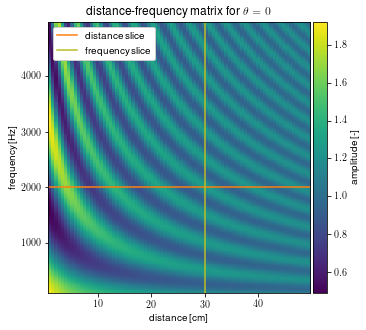

interactive(children=(IntSlider(value=122, continuous_update=False, description='slice_f', max=313), IntSlider…

In [12]:
from plotting_tools import save_fig, add_colorbar
start_freq = 2000,
start_dist = 30,
fig, ax = plt.subplots()
fig.set_size_inches(5, 5)
im = ax.pcolorfast(
    dist, freq, df_matrix_theo[freq_start:freq_end, dist_start:dist_end]
)
add_colorbar(fig, ax, im, title='amplitude [-]')
ax.set_title('distance-frequency matrix for $\\theta=0$')
ax.axhline(start_freq, color='C1', label='distance slice')
ax.axvline(start_dist, color='C8', label='frequency slice')
ax.legend(framealpha=1.0)
ax.set_xlabel('distance [cm]')
ax.set_ylabel('frequency [Hz]')
save_fig(fig, "plots/distance-frequency-matrix.pdf")

matrix_slices(
    df_matrix_theo[freq_start:freq_end, dist_start:dist_end],
    freq,
    dist,
    start_freq=start_freq,
    start_dist=start_dist,
    saveas="plots/distance-frequency-slices.pdf"
)


### vertical frequency slice

max attainable delta: 132.91250000000002
max attainable distance: 62.37093701305632
saved as plots/simulation/noiseless_10_32.pdf
saved as plots/simulation/noiseless_30_32.pdf
saved as plots/simulation/noiseless_60_32.pdf
saved as plots/simulation/noiseless_70_32.pdf
saved as plots/simulation/noiseless_80_32.pdf
max distance 62.37093701305629


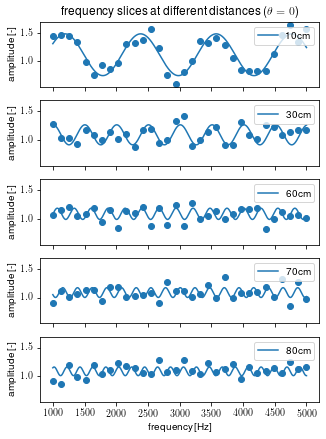

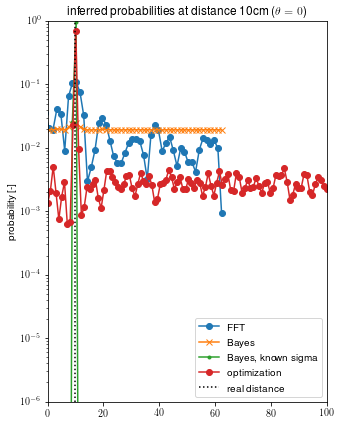

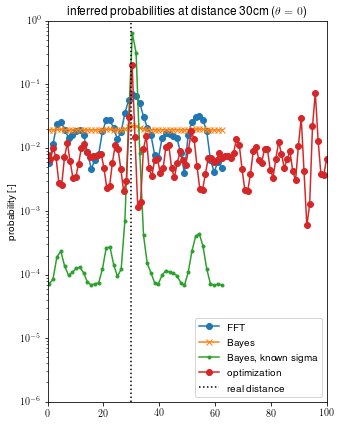

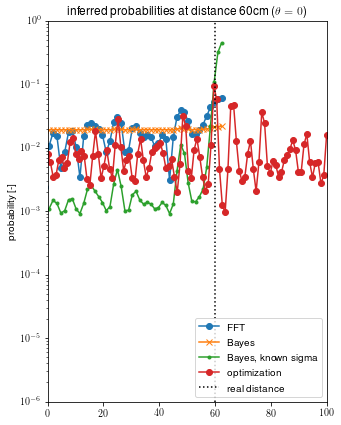

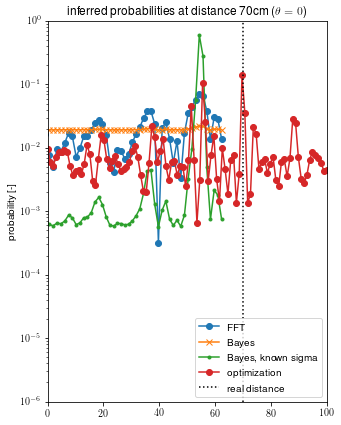

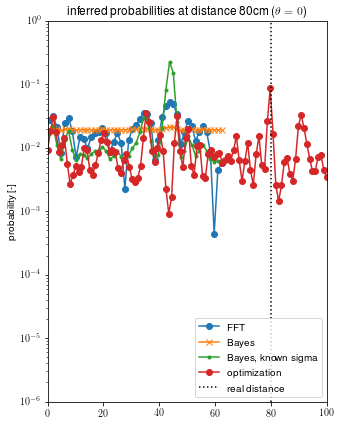

In [19]:
from wall_detector import get_probability_cost, get_probability_fft, get_probability_bayes
from simulation import get_deltas_from_global, SPEED_OF_SOUND

#distance_slices = [5, 10, 20, 30, 40, 50]
distance_slices = [10, 30, 60, 70, 80]

sigma_y = 1e-1 # 1e-1: really good! with 1, it breaks down. with 1e-2, too small.

window = None #'hann' #('tukey', 0.2) #None
max_frequency = 5000
min_frequency = 1000
n_freqs = 32
freq_cont = np.linspace(min_frequency, max_frequency, 1000)
freq = np.linspace(min_frequency, max_frequency, n_freqs)

distances_grid = np.linspace(0, 100, 100)
n_max = 100 # for zero-padding

# highest frequency that we can resolve
df = freq[1]-freq[0]
delta_max = SPEED_OF_SOUND /(2*df) * 100
print('max attainable delta:', delta_max)
from simulation import get_orthogonal_distance_from_global
d = get_orthogonal_distance_from_global(deltas_cm=delta_max, yaw_deg=0, mic_idx=mic_idx)[0]
print('max attainable distance:', d)

fig_all, axs = plt.subplots(len(distance_slices), sharey=True, sharex=True)
axs[0].set_title("frequency slices at different distances ($\\theta=0$)")
height=7
fig_all.set_size_inches(5, height)
for i, d in enumerate(distance_slices):
    idx = np.argmin(np.abs(distances - d))
    slice_cont = get_freq_slice_theory(distance_cm=d, frequencies=freq_cont)[:, mic_idx]
    slice_f = get_freq_slice_theory(distance_cm=d, frequencies=freq)[:, mic_idx]
    
    slice_f += np.random.normal(scale=sigma_y, size=len(slice_f))

    d_fft, p_fft = get_probability_fft(
        slice_f, freq, window=window, n_max=n_max
    )
    p_cost = get_probability_cost(slice_f, freq, distances_grid)
    d_bayes_sigma, p_bayes_sigma = get_probability_bayes(
        slice_f, freq, window=window, n_max=n_max, sigma=sigma_y#n_max
    )
    d_bayes, p_bayes = get_probability_bayes(
        slice_f, freq, window=window, n_max=n_max#n_max
    )
    
    axs[i].set_ylabel("amplitude [-]")
    axs[i].plot(freq_cont, slice_cont, label=f"{d}cm", color="C0")
    axs[i].scatter(freq, slice_f, color="C0")
    axs[i].legend(loc="upper right")

    fig = plt.figure()
    fig.set_size_inches(5, height)
    plt.plot(d_fft, p_fft, marker="o", label="FFT")
    plt.plot(d_bayes, p_bayes, marker="x", label="Bayes")
    plt.plot(d_bayes_sigma, p_bayes_sigma, marker=".", label="Bayes, known sigma")
    plt.plot(distances_grid, p_cost, marker="o", label="optimization")
    plt.axvline(d, ls=":", color="black", label="real distance")
    plt.title(f"inferred probabilities at distance {d}cm ($\\theta=0$)")
    plt.ylabel('probability [-]')
    plt.xlim(min(distances_grid), max(distances_grid))
    plt.legend(loc="lower right")
    #plt.ylim(0, 1)
    plt.yscale("log"); plt.ylim(1e-6, 1)
    save_fig(fig, f"plots/simulation/noiseless_{d:.0f}_{n_freqs}.pdf")
axs[i].set_xlabel("frequency [Hz]")
print('max distance', d_fft[-1])
#save_fig(fig_all, f"plots/simulation/noiseless_slices_{n_freqs}.pdf")

### non-vertical frequency slice

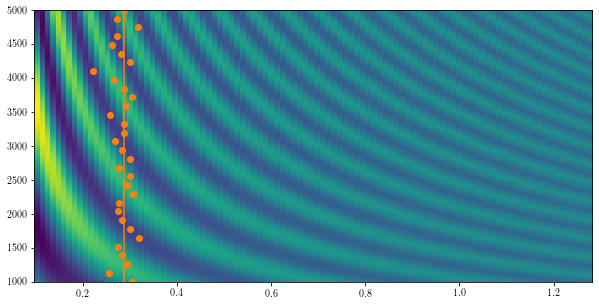

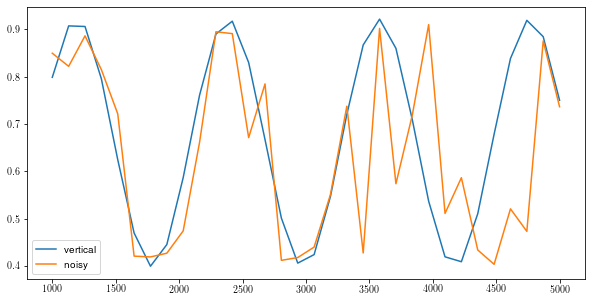

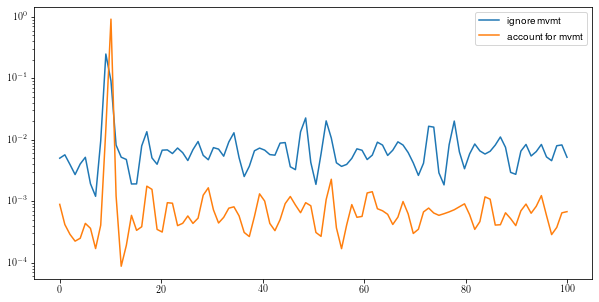

In [21]:
nominal_distance = 10
nominal_yaw = 0
relative_distances = np.random.normal(0, 1, len(freq))
absolute_yaws = np.random.normal(0, 1, len(freq))

deltas, d0 = get_deltas_from_global(yaw_deg=nominal_yaw, 
                                distances_cm=distances, 
                                mic_idx=mic_idx)
nominal_delta, d0 = get_deltas_from_global(nominal_yaw, 
                                       nominal_distance, 
                                       mic_idx)
deltas_noisy, d0 = get_deltas_from_global(nominal_yaw+absolute_yaws, 
                                nominal_distance+relative_distances, 
                                mic_idx)

fig, ax = plt.subplots()
ax.pcolorfast(deltas, frequencies, df_matrix_theo[:-1, :-1])
ax.axvline(nominal_delta, color='C1')
ax.scatter(deltas_noisy, freq, color='C1')
ax.set_ylim(min(freq), max(freq))

df_vert = get_df_theory_simple(nominal_delta, freq) 
slice_f_vert = df_vert.flatten()

df = get_df_theory_simple(deltas_noisy, freq) 
slice_f = np.diag(df)

plt.figure()
plt.plot(freq, slice_f_vert, label='vertical')
plt.plot(freq, slice_f, label='noisy')
plt.legend()

probs_rel = get_probability_cost(slice_f, freq, distances_grid, 
                                 relative_ds=relative_distances, 
                                 absolute_yaws=absolute_yaws)
probs = get_probability_cost(slice_f, freq, distances_grid)
plt.figure()
plt.plot(distances_grid, probs, label='ignore mvmt')
plt.plot(distances_grid, probs_rel, label='account for mvmt')
plt.yscale('log')
plt.legend()

### distance slice

distances: 1.000e-02 m, range: 0.19 m
usable frequencies: 3611 - 34300 Hz
ground truth: 90
expected period 0.1715
estimate: 90.0
distances: 8.660e-03 m, range: 0.1645448267190433 m
usable frequencies: 4169 - 39606 Hz
ground truth: 60
expected period 0.1715
estimate: 52.08283329150142
distances: 5.000e-03 m, range: 0.095 m
usable frequencies: 7221 - 68600 Hz
ground truth: 30
expected period 0.1715
estimate: 39.38661679396194


Text(0, 0.5, 'amplitude [-]')

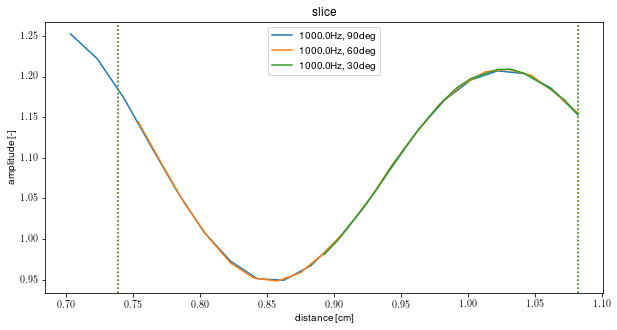

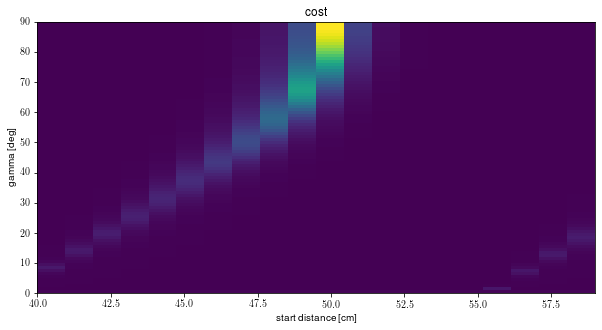

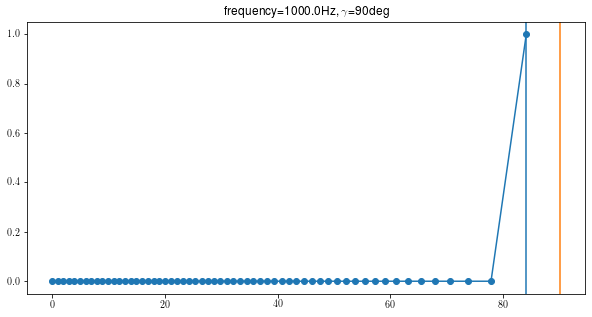

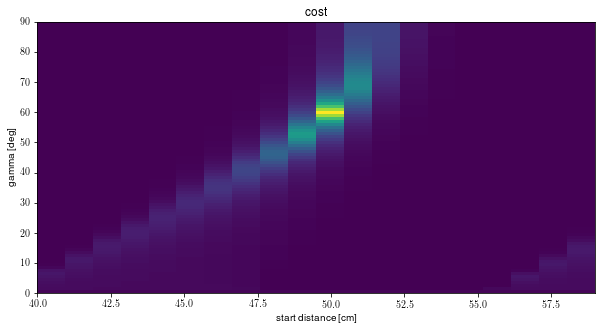

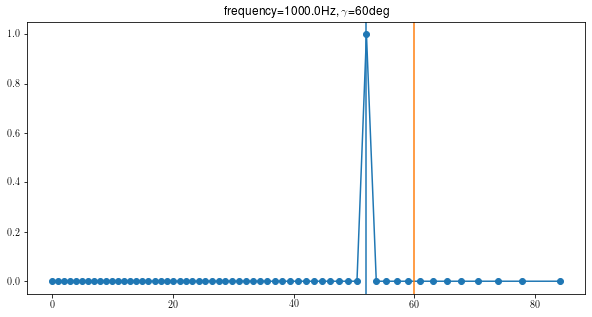

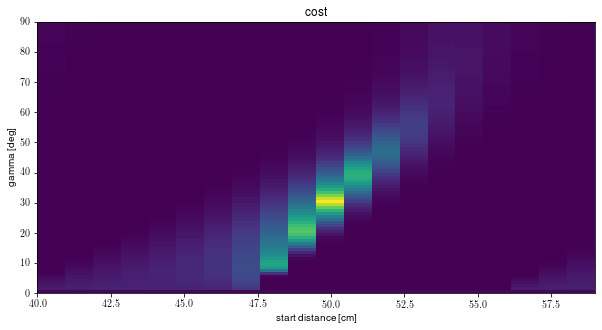

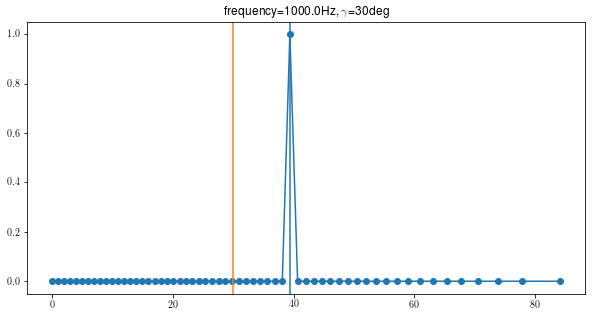

In [27]:
import itertools
from wall_detector import get_approach_angle_fft, get_approach_angle_cost
from simulation import get_orthogonal_distance_from_global

yaw_deg = 0
mic_idx = 1
n_methods = 2

gammas_deg = [90, 60, 30]
frequencies = np.linspace(1000, 5000, 6)[:1]
relative_distances_cm = np.arange(20, step=1.0)
start_distance_cm = 50

start_distances_grid = np.arange(40, 60)
gammas_grid = np.arange(91)

sigma_relative_cm = 0 #1e-5
sigma_y = 1e-3
n_max = 1000

fig, ax_slice = plt.subplots()
fig.set_size_inches(10, 5)
i = 0
for gamma_deg in gammas_deg:
    distances_cm = start_distance_cm - relative_distances_cm * np.sin(gamma_deg / 180 * np.pi)
    deltas_m, d0 = get_deltas_from_global(yaw_deg, distances_cm, mic_idx)
    
    d_m = np.abs(np.mean(np.diff(distances_cm))) * 1e-2
    D_m = (np.max(distances_cm)- np.min(distances_cm)) * 1e-2
    print(f'distances: {d_m:.3e} m, range: {D_m} m')
    print(f'usable frequencies: {2*SPEED_OF_SOUND/D_m:.0f} - {SPEED_OF_SOUND/d_m:.0f} Hz')
    
    print('ground truth:', gamma_deg)
    for frequency in frequencies:
        label = f"{frequency}Hz, {gamma_deg}deg"
        slice_d = get_df_theory_simple(deltas_m, [frequency], flat=True, d0=d0)
        
        slice_d += np.random.normal(scale=sigma_y, size=len(slice_d))
        ax_slice.plot(deltas_m, slice_d, label=label, color=f"C{i}")

        n = max(len(slice_d), n_max)
        d_meters = 1e-2 * (relative_distances_cm[1] - relative_distances_cm[0])
        dist_f = np.fft.rfftfreq(n=n, d=d_meters)
        fft = np.fft.rfft(slice_d - np.mean(slice_d), n=n)

        k_max = np.argmax(np.abs(fft))
        max_dist_f = dist_f[k_max]  # 1/m in terms of relative distance
        period_90 = SPEED_OF_SOUND / (2 * frequency)  # 1/m in terms of distance
        
        ax_slice.axvline(max(deltas_m), ls=":", color=f"C{i}")
        ax_slice.axvline(max(deltas_m)-period_90*2, ls=":", color=f"C{i}")
        
        print('expected period', period_90)
        if max_dist_f == 0:
            cosin_gamma = 0
        else:
            period_here = 1 / max_dist_f  # m
            period_analytical = (d_meters * n) / k_max 
            err = np.abs(period_here - period_analytical)
            assert  err < 1e-10, err
            sin_gamma = period_90 / period_here
            if sin_gamma > 1:
                sin_gamma =1
        print("estimate:", np.arcsin(sin_gamma) * 180 / np.pi)

        sines_gamma, probs_fft = get_approach_angle_fft(
            slice_d, frequency, relative_distances_cm, n_max=n_max, bayes=True, sigma=sigma_y
        )
        gammas_fft = np.arcsin(sines_gamma) * 180 / np.pi

        probs_cost = get_approach_angle_cost(
            slice_d,
            frequency,
            relative_distances_cm,
            start_distances_grid,
            gammas_grid,
            mic_idx=mic_idx,
            #ax=ax,
        )  # is of shape n_start_distances x n_gammas_grid
        slice_d_norm = slice_d - np.mean(slice_d)
        slice_d_norm /= np.std(slice_d_norm)

        fig, ax = plt.subplots()
        ax.pcolorfast(start_distances_grid, gammas_grid, probs_cost.T)
        ax.set_xlabel("start distance [cm]")
        ax.set_ylabel("gamma [deg]")
        ax.set_title("cost")

        plt.figure()
        gamma_max_fft = gammas_fft[np.argmax(probs_fft)]
        plt.plot(gammas_fft, probs_fft, label="fft", color=f"C0", marker='o')
        plt.axvline(gamma_max_fft, color=f"C0")
        
        flat_idx = np.argmax(probs_cost)
        distance_idx, gamma_idx = np.unravel_index(flat_idx, probs_cost.shape)
        gamma_max_cost = gammas_grid[gamma_idx]
        probs_cost_sum = np.max(probs_cost, axis=0)
        probs_cost_sum /= np.sum(probs_cost_sum)
        #plt.plot(gammas_grid, probs_cost_sum, label="cost", color=f"C1")
        plt.axvline(gamma_max_cost, color=f"C1")
        
        plt.title(f"frequency={frequency}Hz, $\gamma$={gamma_deg}deg")
        i += 1
    
ax_slice.legend()
ax_slice.set_title('slice')
ax_slice.set_xlabel('distance [cm]')
ax_slice.set_ylabel('amplitude [-]')

# Geometry study

In [ ]:
from simulation import get_delta
d0 = 5  # [cm]
d_arr = np.arange(5, 50, step=5)
beta_arr = np.linspace(-np.pi, np.pi, 361)
delta_matrix = get_delta(d_arr[None, :], beta_arr[:, None], d0)

fig = plt.figure()
fig.set_size_inches(5, 5)
for j, d in enumerate(d_arr):
    plt.plot(beta_arr * 180 / np.pi, delta_matrix[:, j], label=f"{d}cm")
plt.xlabel("wall angle $\\beta$ [deg]")
plt.ylabel("path difference $d_1-d_0$ [cm]")
l = plt.legend(bbox_to_anchor=[1.0, 1.0], loc="upper left", title="orthogonal \n distance $d$")
plt.setp(l.get_title(), multialignment='center')
plt.grid()

In [ ]:
import matplotlib as mpl
mpl.rc('text', usetex = True)

from plotting_tools import save_fig
from simulation import get_orthogonal_distance

d0 = 5
delta_arr = np.arange(10, 100, step=10)
beta_arr = np.linspace(-np.pi, np.pi, 361)
d_matrix = get_orthogonal_distance(delta_arr, beta_arr, d0)

fig = plt.figure()
fig.set_size_inches(5, 5)
for j, d in enumerate(delta_arr):
    plt.plot(beta_arr * 180 / np.pi, d_matrix[:, j], label=f"{d}cm")
plt.xlabel("wall angle $\\beta$ [deg]")
plt.ylabel("orthogonal distance $d$ [cm]")
plt.grid(which="both")
l = plt.legend(bbox_to_anchor=[1.0, 1.0], loc="upper left", title="path difference \n $d_1 - d_0$")
plt.setp(l.get_title(), multialignment='center')
save_fig(fig, "plots/theory_distances.png")

## Noise study

All below depends on the nominal distance from the wall. We could make median performance vs. distance error and distance from wall plots, and repeat the same plot at different amplitude noises.

Preliminary studies:

- Find correct parameters for attenuation and wall loss, given our experimental data. Will be different from wall to wall! We can get different wall estimate from pyroomacoustics. 

Noise sensitivity plots:

- Add noise on "where" we measure: We think we are at d, but actually measure at d+epsilon. Or we think we are at theta, but actually measure at theta+epsilon. Both lead to an error in path length, so we can add noise on the path length and then translate that noise to theta and/or distance errrors (on separate y labels)

- Add noise on amplitudes. Check how high this is in practice for different settings (with/without motors, hovering or fixed, different windowing techniques, with/without interpolation, etc.)

Separate plot: 

- Add noise on frequencies to make them non-uniform (but known)

In [ ]:
from simulation import get_deltas_from_global
mic_idx = 3
frequencies = np.linspace(1000, 5000, 100)
distances_cm = np.arange(50, step=5)
yaw_deg = np.arange(-180, 180)

sigmas_distance = np.arange(20)
sigmas_yaw = np.arange(-180, 180) 

fig, axs = plt.subplots(1, 2, sharey=True)
fig.set_size_inches(5, 5)
for d in distances_cm[::len(distances_cm)//10]:
    delta, d0 = get_deltas_from_global(0, d, mic_idx)
    delta_noisy, d0 = get_deltas_from_global(sigmas_yaw, d, mic_idx)
    sigmas_delta = 1e2 * abs(delta - delta_noisy)
    axs[0].plot(sigmas_yaw, sigmas_delta, label=f'{d}cm') 
axs[0].set_xlabel('$\\sigma_\\theta [deg]$')
axs[0].set_ylabel('$\\sigma_\\Delta [cm]$')
axs[0].legend(loc='upper left', title='distance $d$')
    
for yaw in yaw_deg[::len(yaw_deg)//10]:
    delta, d0 = get_deltas_from_global(yaw, 0, mic_idx)
    delta_noisy, d0 = get_deltas_from_global(yaw, sigmas_distance, mic_idx)
    sigmas_delta = 1e2 * abs(delta - delta_noisy)
    axs[1].plot(sigmas_distance, sigmas_delta, label=f'{yaw}deg') 
axs[1].set_xlabel('$\\sigma_d$ [cm]')
axs[1].legend(loc='upper left', title='angle $\\theta$')
axs[1].set_ylim(-1, 45)
save_fig(fig, "plots/simulation/noise_study.pdf")

## frequency slices

In [ ]:
labels = {
    'fft': 'FFT method',
    'cost': 'optimization method',
    'sigmadelta': 'delta noise $\sigma_\\Delta$ [cm]',
    'sigmay': 'amplitude noise $\sigma_y$ [-]',
    'distance': 'distance $d$ [cm]',
    np.nanstd: 'error std',
    np.nanmedian: 'median error',
}

def pcolorfast_custom(ax, xs, ys, values, verbose=False, **kwargs):
    """ pcolorfast with gray for nan and centered xticks and yticks. 
    """
    import matplotlib
    current_cmap = matplotlib.cm.get_cmap()
    current_cmap.set_bad(color='gray')
    
    assert values.shape == (len(ys), len(xs))
    
    try:
        im = ax.pcolorfast(xs, ys, values, **kwargs)
        dx = (xs[1] - xs[0]) # assumes uniform samples 
        dy = (ys[1] - ys[0])
        yticks = ys + dy/2 
        xticks = xs + dx/2
        ax.set_xticks(xticks)
        ax.set_xticklabels(xs)
        ax.set_yticks(yticks)
        ax.set_yticklabels(ys)
        extent = [xs[0], xs[-1]+dx, ys[0], ys[-1]+dy]
        im.set_extent(extent)
    except:
        print('Warning: problem with dimensions in pcolorfast (bug by matplotlib)')
        im = ax.pcolorfast(xs, ys, values[:-1, :-1], **kwargs)
    return im

def plot_error(sub_df, column, name, log=False, aggfunc=np.nanmedian, vmin=None, vmax=None):
    from plotting_tools import add_colorbar
    table = pd.pivot_table(sub_df, values='error', index=['method', column], columns='distance', 
                           aggfunc=aggfunc)
    nonzero_values = table.values[table.values > 0]
    if vmin is None and len(nonzero_values):
        vmin = np.min(nonzero_values)
    if vmax is None and len(nonzero_values):
        vmax = np.max(nonzero_values)
        
    fig, axs = plt.subplots(1, len(sub_df.method.unique()), sharey=True, squeeze=False)
    fig.set_size_inches(5*len(sub_df.method.unique()), 5)
    for i, (method, df) in enumerate(table.groupby('method')):
        index = df.index.get_level_values(column).values
        distances = df.columns.values
        if log: 
            im = pcolorfast_custom(axs[0, i], distances, index, np.log10(df.values), vmin=np.log10(vmin), vmax=np.log10(vmax))
        else:
            im = pcolorfast_custom(axs[0, i], distances, index, df.values, vmin=vmin, vmax=vmax)
        axs[0, i].set_xlabel('distance $d$ [cm]')
        axs[0, i].set_title(labels[method])
    add_colorbar(fig, axs[0, -1], im, title=f'{labels[aggfunc]} [cm]')
    axs[0, 0].set_ylabel(name.replace('_', ' '))
    return fig, axs

In [ ]:
from pandas_utils import filter_by_dict
from plotting_tools import save_fig

# TODO(FD) verify that below holds with a different gain too.

def get_cos_amplitudes(distances_cm):
    from simulation import WALL_ABSORPTION, GAIN

    distances_cm = results_df.distance.unique()
    deltas_m, d0 = get_deltas_from_global(
        distances_cm=distances_cm, mic_idx=mic_idx, yaw_deg=0
    )
    alpha0 = 1 / (4 * np.pi * d0)
    alpha1 = (1 - WALL_ABSORPTION) / (4 * np.pi * (deltas_m + d0))
    cos_amplitudes = GAIN * 2 * alpha0 * alpha1
    return cos_amplitudes


def plot_cos_amplitudes(axs, results_df):
    distances_cm = results_df.distance.unique()
    cos_amplitudes = get_cos_amplitudes(distances_cm)
    for i, f in enumerate([1.0, 1.5, 2.0]):
        for ax in axs.flatten():
            ax.plot(
                distances_cm,
                f * cos_amplitudes,
                color=f"C{i}",
                label=f"$\\sigma_y=${f}$a(d)$",
            )
    [ax.set_ylim(None, results_df.sigmay.max()) for ax in axs.flatten()]
    axs[0, -1].legend(loc="upper right", framealpha=1.0)
    
    
def plot_cuts(results_df, category_label = 'sigmadelta', xlabel = 'distance', num_cuts=3):
    methods = results_df.method.unique()
    fig, axs = plt.subplots(1, len(methods), squeeze=False, sharey=True)
    fig.set_size_inches(5*len(methods), 5)
    for i, (method, sub_df) in enumerate(results_df.groupby('method')):
        categories = sub_df[category_label].unique()
        
        idx = np.linspace(1, len(categories)-1, num_cuts).astype(int)
        for category in categories[idx]:
            df = sub_df.loc[sub_df[category_label]==category]
            if not len(df):
                print(f'did not find {category} in {sub_df[category_label].unique()}')
                continue
            medians = df.groupby(xlabel).error.median()
            axs[0, i].plot(medians.index, medians.values, marker='o')
        #axs[0, i].set_yscale('log')
        axs[0, i].set_title(f'{labels[method]}')
        axs[0, i].set_xlabel(labels[xlabel]) #('distance $d$ [cm]')
        axs[0, i].legend(np.round(categories[idx], 1), title=labels[category_label])
    axs[0, 0].set_ylabel('median error [cm]')
    return fig, axs 
    
    

In [ ]:
name = "amplitude_noise"
results_df = pd.read_pickle(f"results/simulation/{name}.pkl")

fig, axs = plot_error(
    results_df, column="sigmay", name=name + " $\\sigma_y$ [-]", aggfunc=np.nanmedian
)
plot_cos_amplitudes(axs, results_df)
save_fig(fig, f"plots/simulation/{name}_median.pdf")
for method, sub_df in results_df.groupby("method"):
    fig, axs = plot_error(
        sub_df, column="sigmay", name=name + " $\\sigma_y$ [-]", aggfunc=np.nanmedian
    )
    plot_cos_amplitudes(axs, results_df)
    save_fig(fig, f"plots/simulation/{name}_{method}_median.pdf")

    fig, axs = plot_error(
        sub_df, column="sigmay", name=name + " $\\sigma_y$ [-]", aggfunc=np.nanstd
    )
    plot_cos_amplitudes(axs, results_df)
    save_fig(fig, f"plots/simulation/{name}_{method}_std.pdf")
    
    fig, axs = plot_cuts(sub_df, category_label='distance', xlabel='sigmay', num_cuts=3)
    save_fig(fig, f"plots/simulation/{name}_{method}_slice.pdf")

In [ ]:
#name = 'delta_noise_high'
name = 'delta_noise'
results_df = pd.read_pickle(f'results/simulation/{name}.pkl')

fig, axs = plot_error(results_df, column='sigmadelta', name=name + ' [cm]', aggfunc=np.nanmedian)
save_fig(fig, f'plots/simulation/{name}_median.pdf')
fig, axs = plot_error(results_df, column='sigmadelta', name=name + ' [cm]', aggfunc=np.nanstd)
save_fig(fig, f'plots/simulation/{name}_std.pdf')

for method, sub_df in results_df.groupby('method'):
    
    fig, axs = plot_error(sub_df, column='sigmadelta', name=name + ' [cm]', aggfunc=np.nanmedian)
    axs[0, 0].set_title(f"median error of {labels[method]}")
    save_fig(fig, f'plots/simulation/{name}_{method}_median.pdf')
    
    fig, axs = plot_error(sub_df, column='sigmadelta', name=name + ' [cm]', aggfunc=np.nanstd)
    axs[0, 0].set_title(f"error std of {labels[method]}")
    save_fig(fig, f'plots/simulation/{name}_{method}_std.pdf')

In [ ]:
name = 'delta_noise'
results_df = pd.read_pickle(f'results/simulation/{name}.pkl')
for method, sub_df in results_df.groupby('method'):
    sub_df = sub_df.loc[sub_df.distance >= 10]
    fig, axs = plot_cuts(sub_df, category_label='distance', xlabel='sigmadelta', num_cuts=10)
    save_fig(fig, f"plots/simulation/{name}_{method}_distance_cuts.pdf")
    
    fig, axs = plot_cuts(sub_df, category_label='sigmadelta', xlabel='distance', num_cuts=3)
    save_fig(fig, f"plots/simulation/{name}_{method}_delta_cuts.pdf")

In [ ]:
name = 'frequency_noise'
results_df = pd.read_pickle(f'results/simulation/{name}.pkl')
vmin = results_df.error.min()/2
vmax = results_df.error.max()/2
for method, sub_df in results_df.groupby('method'):
    fig, axs = plot_error(sub_df, column='sigmaf', name=name + ' [Hz]', aggfunc=np.nanmedian, vmin=vmin, vmax=vmax)
    save_fig(fig, f'plots/simulation/{name}_{method}_median.pdf')
    fig, axs = plot_error(sub_df, column='sigmaf', name=name + ' [Hz]', aggfunc=np.nanstd, vmin=vmin, vmax=vmax)
    save_fig(fig, f'plots/simulation/{name}_{method}_std.pdf')

In [ ]:
name = 'joint_noise'
results_df = pd.read_pickle(f'results/simulation/{name}.pkl')

chosen_sigmas = results_df.sigmay.unique()
chosen_sigmas = chosen_sigmas[::len(chosen_sigmas)//3]

for sigma_y in chosen_sigmas:
    print('plotting', sigma_y)
    
    sub_df = filter_by_dict(results_df, {'sigmay':sigma_y})
    for method, sub_df in sub_df.groupby('method'):
        #fig, axs = plot_error(sub_df, column='sigmadelta', name='delta noise', aggfunc=np.nanstd)
        #fig.suptitle(f'amplitude noise: {sigma_y}')
        fig, axs = plot_error(sub_df, column='sigmadelta', name='delta noise [cm]', aggfunc=np.nanmedian, vmax=30)
        axs[0, 0].set_title(f'{labels[method]}, amplitude noise [-]: {sigma_y}')
        save_fig(fig, f'plots/simulation/{name}_{method}_{str(sigma_y).replace(".","-")}_median.pdf')

## distance slices

In [ ]:
def plot_error_gamma(sub_df, column, name, log=False, aggfunc=np.nanmedian, vmin=None, vmax=None):
    from plotting_tools import add_colorbar
    table = pd.pivot_table(sub_df, values='error', index=['method', column], columns='gamma', 
                           aggfunc=aggfunc)
    nonzero_values = table.values[table.values > 0]
    if vmin is None and len(nonzero_values):
        vmin = np.min(nonzero_values)
    if vmax is None and len(nonzero_values):
        vmax = np.max(nonzero_values)
        
    fig, ax = plt.subplots()
    fig.set_size_inches(5, 5)
    
    index = table.index.get_level_values(column).values
    gammas = table.columns.values
    if log: 
        im = pcolorfast_custom(ax, gammas, index, np.log10(table.values), vmin=np.log10(vmin), vmax=np.log10(vmax))
    else:
        im = pcolorfast_custom(ax, gammas, index, table.values, vmin=vmin, vmax=vmax)
    ax.set_xlabel('approach angle $\\gamma$ [deg]')
    ax.set_title(labels[method])
    add_colorbar(fig, ax, im, title=f'{labels[aggfunc]} [deg]')
    ax.set_ylabel(name.replace('_', ' '))
    return fig, ax

In [ ]:
name = "angle_noiseless"
results_df = pd.read_pickle(f'results/simulation/{name}.pkl')

In [ ]:
for method, sub_df in results_df.groupby('method'):
    fig, ax = plot_error_gamma(sub_df, column='frequency', name='frequency [Hz]', aggfunc=np.nanstd)
    save_fig(fig, f'plots/simulation/{name}_{method}_std.pdf')
    fig, ax = plot_error_gamma(sub_df, column='frequency', name='frequency [Hz]', aggfunc=np.nanmedian)
    save_fig(fig, f'plots/simulation/{name}_{method}_median.pdf')
sub_df